# Robustness of an Image Classification Network

This notebook is adapted from [1].

### References

[1] https://github.com/sisl/NeuralVerification.jl/blob/master/examples/cars_workshop/5%20image%20classification.ipynb

## MNIST Data set

In this notebook we will inspect networks trained to classify hand-written digits from the MNIST dataset. We will load the pretrained networks (similar to those produced in the training notebook) and then inspect them to find an adversarial example - an input point close to an original training point that produces and undesirable output, in this case a missclassification error.

The MNIST dataset is composed of handwritte digits as shown below. Each sample is a grayscale image (with a single 8 bit channel) of 28 x 28 pixels.

 ![caption](https://github.com/sisl/NeuralVerification.jl/blob/master/examples/cars_workshop/img/mnistexamples.png?raw=true)

## Classification Network

Each input point is reshaped into a $28 \times 28 = 784$ dimensional vector with each value in the $[0, 255]$ range, where $255$ corresponds to white and $0$ to black. The networks, which in this case have a fully connected feed-forward architecture with ReLU activation functions output 10 scores, one corresponding to each of the $0-9$ digits. The input image is classified with the label that corresponds to the maximum score outputted by the network.

## Adversarial Example

It is widely known that Deep Neural Networks (DNNa) are suceptible to adversarial perturbations. In this example this means that slight changes in points that are correctly classified can be misclassified. We will use NeuralVerification.jl to find such an example.

Recall that for a given network $f(x)$, Input Set $\mathcal{X}$ and Output set $\mathcal{Y}$, the verification problems consists of concluding whether

$$\ x\in \mathcal{X} \Rightarrow  y= f( x)\in \mathcal{Y}$$

holds or not. When this condition does not hold some of the algorithms implemented in NeuralVerification.jl return a counter example, that is a point $x \in \mathcal{X}$ such that $f(x) \notin \mathcal{Y}$ which is equivalent to $x \in \mathcal{X} \wedge f(x) \in \mathcal{Y}^C$.

We will construct the Input Set $\mathcal{X}$ with points close to a correctly classified sample and the Output Set $\mathcal{Y}$ to contain the score distributions that correspond to correctly classifying the point. In this way, if a counter example is returned it will be a point that lays close to the correctly classified point but with a score distribution where the score corresponding to the label of the original input point is not maximal.

# Loading the requirements

In [6]:
using NeuralVerification, LazySets, Test, LinearAlgebra, GLPKMathProgInterface
import NeuralVerification: ReLU, Id
using PyPlot

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278


## Loading the networks

We load the networks contained as examples in NeuralVerification.jl

In [7]:
models_dir = "/home/mforets/.julia/dev/NeuralVerification/examples/cars_workshop/models"

"/home/mforets/.julia/dev/NeuralVerification/examples/cars_workshop/models"

In [10]:
mnist1_file = joinpath(models_dir, "mnist1.nnet")
mnist2_file = joinpath(models_dir, "mnist2.nnet")
mnist3_file = joinpath(models_dir, "mnist3.nnet")
mnist4_file = joinpath(models_dir, "mnist4.nnet")

mnist1 = read_nnet(mnist1_file, last_layer_activation = Id())
mnist2 = read_nnet(mnist2_file, last_layer_activation = Id())
mnist3 = read_nnet(mnist3_file, last_layer_activation = Id())
mnist4 = read_nnet(mnist4_file, last_layer_activation = Id());

In [11]:
dump(mnist1)

Network
  layers: Array{NeuralVerification.Layer}((2,))
    1: NeuralVerification.Layer{ReLU,Float64}
      weights: Array{Float64}((25, 784)) [-0.0145822 -0.10073 … 0.0317891 -0.121057; 0.0927983 0.0378668 … -0.170367 0.0468094; … ; 0.106251 -0.0527935 … -0.152655 -0.159538; -0.0353035 0.107237 … -0.15136 -0.11534]
      bias: Array{Float64}((25,)) [0.250202, -0.0460057, 0.197282, 0.206724, 0.19505, 0.123348, 0.195402, 0.195682, 0.270503, 0.0789479  …  0.00734778, 0.195026, 0.139418, 0.188492, 0.36361, -0.0787834, 0.209898, 0.276816, 0.103367, 0.239872]
      activation: ReLU ReLU()
    2: NeuralVerification.Layer{Id,Float64}
      weights: Array{Float64}((10, 25)) [-0.048196 0.0694253 … -0.147897 -0.0522713; -0.165646 0.0419264 … -0.0298784 0.308652; … ; -0.0234716 0.233258 … -0.0833671 0.0769656; 0.253074 0.0652968 … -0.0465979 0.124504]
      bias: Array{Float64}((10,)) [0.0894416, 0.23172, 0.113948, 0.0927643, 0.180114, 0.294576, 0.107671, 0.216698, -0.0553405, 0.108553]
      act

## Defining the problem

In order to define the problem we need a network, which we will select from the ones previously loaded, an Input Set $\mathcal{X}$ and an Output Set $\mathcal{Y}$.

### Input Set

To define the Input Set we begin with a data point in the training set. For this example we selected the following image which corresponds to a hand-written digit $1$.

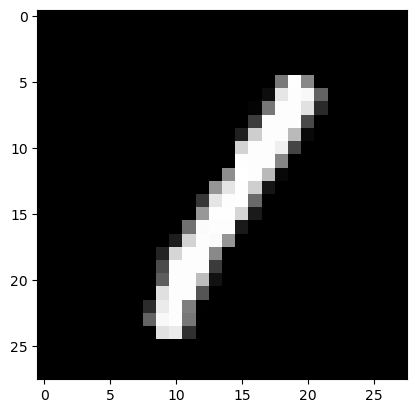

PyObject <matplotlib.image.AxesImage object at 0x7fef720dd950>

In [13]:
input_center = [0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,230,253,248,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,118,253,253,225,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,253,253,253,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,206,253,253,186,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,211,253,253,239,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,254,253,253,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,142,255,253,186,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,149,229,254,207,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,229,253,254,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,254,254,213,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,112,251,253,253,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,212,253,250,149,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,214,253,253,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,253,253,253,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93,253,253,189,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,224,253,253,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,235,253,126,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,248,253,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,225,235,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
X = reshape(input_center, 28, 28)'
imshow(X, cmap=:gray, clim=(0,255))

Notice that the network correctly classifies this image as as $1$:

In [14]:
scores = NeuralVerification.compute_output(mnist3, input_center)

10-element Array{Float64,1}:
 -1629.2302589012768
  2720.09014887375
   -89.66814654856465
    29.31700703467395
   115.33444359444309
 -2863.4869100532223
  -724.9086493556797
  1245.998599490938
   408.713853247963
  -374.98230616425457

In [15]:
input_center_label = argmax(scores)-1
input_center_label

1

We then build a hyperrectangle around it by defining an $\epsilon$ and including all the points that can be reached by deviating at most $\epsilon$ from the original image in every dimension. Note that this could cause the set to include points with pixel values below $0$ or above $255$ which would be outside of the range so we have clipped these values.

In [16]:
epsilon = 40
upper = input_center .+ epsilon
lower = input_center .- epsilon
clamp!(upper, 0.0, 255.0)
clamp!(lower, 0.0, 255.0)

X = Hyperrectangle(low=lower, high=upper)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0  …  20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0], [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0  …  20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0])

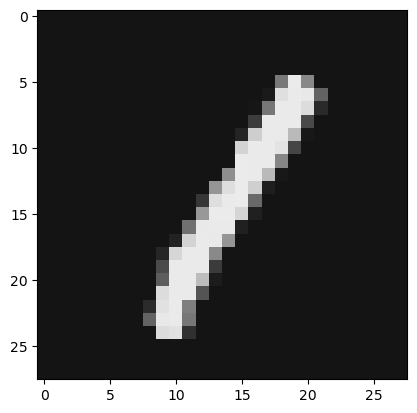

PyObject <matplotlib.image.AxesImage object at 0x7fefd0064bd0>

In [23]:
v = X.center
v = reshape(v, 28, 28)'
imshow(v, cmap=:gray, clim=(0,255))

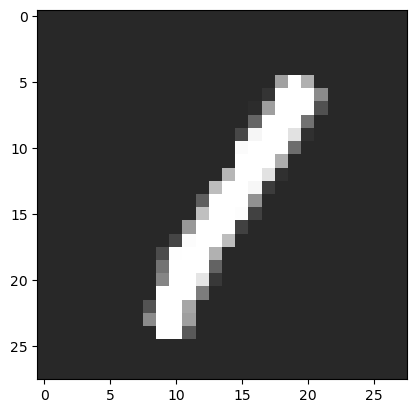

PyObject <matplotlib.image.AxesImage object at 0x7fef7141ce90>

In [24]:
v = σ(fill(1.0, 784), X)
v = reshape(v, 28, 28)'
imshow(v, cmap=:gray, clim=(0,255))

In [31]:
using NetworkBackpropagation
const NB = NetworkBackpropagation

NetworkBackpropagation

In [55]:
_convert(::NeuralVerification.Id) = NB.Id
_convert(::NeuralVerification.ReLU) = NB.ReLU

L = []

for Li in mnist3.layers
    W = Li.weights
    b = Li.bias
    a = _convert(Li.activation)
    Li = NB.Layer(W, b, a)
    push!(L, Li)
end

net = NB.Network(L);

In [56]:
NB.forward(input_center, net) # OK

10-element Array{Float64,1}:
 -1629.2302589012768
  2720.09014887375
   -89.66814654856465
    29.31700703467395
   115.33444359444309
 -2863.4869100532223
  -724.9086493556797
  1245.998599490938
   408.713853247963
  -374.98230616425457

In [57]:
scores = NeuralVerification.compute_output(mnist3, input_center)

10-element Array{Float64,1}:
 -1629.2302589012768
  2720.09014887375
   -89.66814654856465
    29.31700703467395
   115.33444359444309
 -2863.4869100532223
  -724.9086493556797
  1245.998599490938
   408.713853247963
  -374.98230616425457

In [62]:
NB.backward(Singleton(scores), net)

LoadError: AssertionError: inverse rectification not implemented for dimension 25

## Output set

As stated earlier, the network is trained to output 10 scores, one corresponding to each of the digits between $0$ and $9$. We then assign the label that corresponds to the maximal score. This means that in order to correctly classify the previous image we need the second score (which corresponds to $1$) to be maximal.

The goal of this exercise is to find a point very close to that image that the networks misclassifies. In order to find such an input we want to define the Output Set $\mathcal{Y}$ such that the counter example produced to falsify the property is not classified as a $1$. This imples that we need $\mathcal{Y}^C$ to contain only points score distributions where $y_2$ is not maximal.

### A note on ComplementPolytopes

Consider the set of all the score distributions that correspond to classifying the image as $1$. This set is made of all the points where $y_2$ is maximal. That is 
$$ Label_2 = \left \{ Y \mid y_2 = \max_{i=1..10}\left \{y_i \right \} \right \} $$

This is equivalent to the set of outputs $Y$ that satisfies:

$$ (y_1 \leq y_2) \wedge (y_3 \leq y_2) \wedge \dots \wedge (y_10 \leq y_2) $$

Which is the polytope formed by intersecting all the halfspaces from the previous conditions and as such can be represented as a linear inequality of the form:
$$ Ay \leq b $$

With the following matrix $A$ and $b$:

$$
\underbrace{\begin{bmatrix}
1 & -1 &  0&  0&  0&  0&  0&  0&  0& \\ 
 0& -1 &  1&  0&  0&  0&  0&  0&  0& \\ 
 0&  -1&  0&  1&  0&  0&  0&  0&  0& \\ 
 0&  -1&  0&  0&  1&  0&  0&  0&  0& \\ 
 0&  -1&  0&  0&  0&  1&  0&  0&  0& \\ 
 0&  -1&  0&  0&  0&  0&  1&  0&  0& \\ 
 0&  -1&  0&  0&  0&  0&  0&  0&  0& \\ 
 0&  -1&  0&  0&  0&  0&  0&  1&  0& \\ 
 0&  -1&  0&  0&  0&  0&  0&  0&  1& 
\end{bmatrix}}_{A}
\underbrace{\begin{bmatrix}
y_1\\ 
y_2\\ 
y_3\\ 
y_4\\ 
y_5\\ 
y_6\\ 
y_7\\ 
y_8\\
y_9\\
y_{10}\\ 
\end{bmatrix}}_{y}
\leq
\underbrace{\begin{bmatrix}
0\\ 
0\\ 
0\\ 
0\\ 
0\\ 
0\\ 
0\\ 
0\\
0\\
0\\ 
\end{bmatrix}}_{b}
$$

So we would ideally like to define the set of $\mathcal{Y}$ to correspond to this polytope so that $\mathcal{Y}^C$ contains all the scores that correspond to misclassifying. However, many optimization algorithms complement $\mathcal{Y}$ internally often aiming to solve a feasability problem encoded with lineawr constraints. This imposes the requirement that $\mathcal{Y}^C$ can only be represented as a set of conjunctive linear constraints, again with the form $By\leq b$.

For this end the $\texttt{PolytopeComplement}$ class was created and its goal is to enable the user to define the Output Set $\mathcal{Y}$ that corresponds to the complement of a convex polytope - which means that $\mathcal{Y}^C$ is of the form $Ay \leq b$.

### Now back to our problem

Recall that we want our procedure to produce a counter example (ie. find an $x \in \mathcal{X} \ st. \ f(x) \in \mathcal{Y}^C$. 

So we want $\mathcal{Y}^C$ to correspond to the distributions of scores where $y_2$ is not maximal. We previously showed that the set where $y_2$ is maximal is a convex polytope and this implies that its complement is not. In order to represent the whole complement we would need a set of disjunctive conditions which we cannot encode in the form of $By\leq c$. In other terms, this means that we are looking for points where $y_2 \leq y_1$ or $y_2 \leq y_3$ or $y_2 \leq y_4$ and so on. We can however prune this set by enforcing only one of those constraints to find a point that lays at least in a subset of the complete set.

So instead we arbitrarily select one of the scores that corrrespond to a digit different that $1$ and use it to build a halfspace where the score associated to this digit is greater than the score associated to $1$. In the following example we arbitrarily chose the score associated to the digit $8$.

In [6]:
A = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0]'
b = [0.0]

Yc = HPolytope(A, b)
Y = complement(Yc)



PolytopeComplement of:
  HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0], 0.0)])


### Solving the problem

We finally define the problem object and run the algorithm.

In [7]:
problem_mnist = Problem(mnist3, X, Y)

solver = NSVerify(m=100)
solver=Reluplex()
println("NSVerify - mnist1")
timed_result = @timed solve(solver, problem_mnist)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])
println("")

counter_example = timed_result[1].counter_example;

NSVerify - mnist1
 - Time: 28.138687898 s - Output: CounterExampleResult(:violated, [40.0, 40.0, 0.0, 0.0, 0.0, -5.53379e-13, 40.0, 0.0, 2.13163e-14, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 40.0, 40.0, -3.12639e-13, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, -5.68434e-14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 40.0, 40.0, 0.0, 40.0, 0.0, 0.0, 0.0, 9.73073e-14, 40.0, 40.0, 3.144, 40.0, 0.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 40.0, 40.0, 2.77112e-13, 40.0, -3.01717e-13, 0.0, 0.0, 0.0, 0.0, 0.0, 8.52651e-14, -1.49214e-13, 0.0, 2.84217e-14, 0.0, 40.0, 40.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 40.0, 40.0, 40.0, 40.0, 40.0, 0.0, 0.0, 40.0, 40.0, 0.0, 0.0, 0.0, 9.86036, 40.0, 0.0, 0.0, 40.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0

The algorithm returned a counter example which corresponds to the following image.

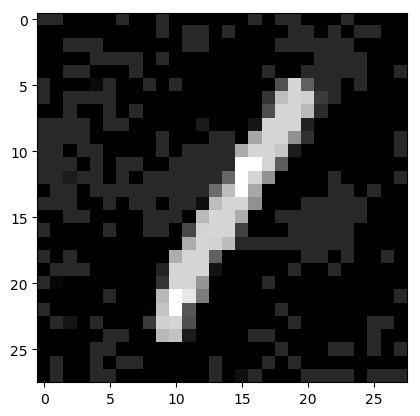

PyObject <matplotlib.image.AxesImage object at 0x14b9070f0>

In [8]:
imshow(reshape(counter_example, 28, 28)', cmap=:gray, clim=(0,255))

We can agree that this image closely resembles a hand-written digit $1$. But given how we constructed the problem the network did not classify it as a $1$. Let's take a look.

### Classification outcome

If we feed this point through the network it produces the following scores.

In [9]:
output_scores = NeuralVerification.compute_output(mnist3, counter_example)

10-element Array{Float64,1}:
 -342.2761483644186  
  172.14072548118477 
   22.81275466205807 
  -38.50119246229842 
 -393.45695272113505 
 -164.72782336024417 
 -231.51173385356634 
  -48.316163527486296
  693.0404469496182  
  -15.815705339473023

In [12]:
output_scores ∈ Y

false

In [13]:
output_scores ∈ Yc

true

And by looking at the maximum score we can obtain the associated label

In [14]:
output_label = argmax(NeuralVerification.compute_output(mnist3, counter_example))-1
output_label

8

Which means the network classified that point as a number $8$.

## Perturbation

We now take a look at the peturbation applied to the original image that leads to the aversarial example

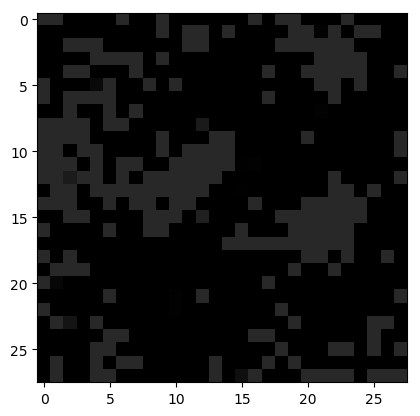

PyObject <matplotlib.image.AxesImage object at 0x14bb3d1d0>

In [15]:
perturbation = counter_example - input_center
#clamp!(perturbation, 0, 250)
imshow(reshape(perturbation, 28, 28)' ,cmap=:gray, clim=(0,255))

# Now lets play with the parameters

We have shown that by defining the Input and Output sets appropriately NeuralVerification.jl can be used to find adversarial examples for a classification network. Now lets see if we can find more interesting adversarial examples by selecting different output sets and values of $\epsilon$ for the input set.


In [16]:
epsilon = 40
digitHalfspace = 9

upper = input_center .+ epsilon
lower = input_center .- epsilon
clamp!(upper, 0.0, 255.0)
clamp!(lower, 0.0, 255.0)
X = Hyperrectangle(low=lower, high=upper)

A = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]'
A[digitHalfspace+1] = -1.0
b = [0.0]
Yc = HPolytope(A, b)
Y = complement(Yc)

problem_mnist = Problem(mnist3, X, Y)

solver = NSVerify(m=100)
solver=Reluplex()
println("NSVerify - mnist1")
timed_result = @timed solve(solver, problem_mnist)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])
println("")

counter_example = timed_result[1].counter_example;

NSVerify - mnist1
 - Time: 21.960377679 s - Output: CounterExampleResult(:violated, [40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 8.92983, 0.0, 3.55271e-14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 40.0, 40.0, 40.0, 14.9659, 0.0, 0.0, 0.0, 40.0, 40.0, 40.0, 40.0, 40.0, 0.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 40.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 40.0, 40.0, 40.0, 31.2775, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 40.0, 40.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 40.0, 40.0, 40.0, 0.0, 0.0, 40.0, 40.0, 40.0, 0.0, 40.0, 40.0, 31.5597, 40.0, 0.0, 40.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.0, 214.0, 96.0, 40.0, 0.0, 40.0, 0.0, 0.0, 0.0,

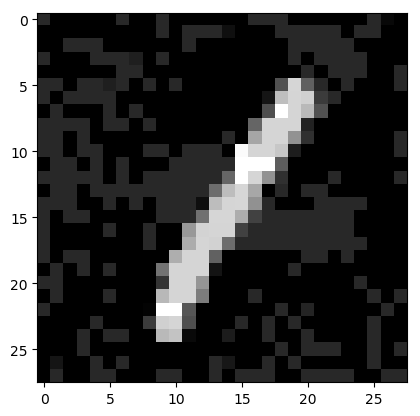

PyObject <matplotlib.image.AxesImage object at 0x145113d68>

In [17]:
imshow(reshape(counter_example, 28, 28)', cmap=:gray, clim=(0,255))

In [18]:
output_label = argmax(NeuralVerification.compute_output(mnist3, counter_example))-1
output_label

8

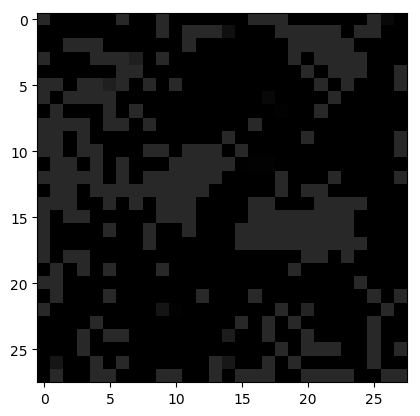

PyObject <matplotlib.image.AxesImage object at 0x145088b38>

In [19]:
perturbation = counter_example - input_center
imshow(reshape(perturbation, 28, 28)' ,cmap=:gray, clim=(0,255))